In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn_image as isns
import tensorflow as tf
from PIL import Image
import rawpy, imageio, cv2
import os, shutil
import graphviz, pydot
import random

In [3]:
train_meta_loc = "./dataset/Sony_train_list.txt"
test_meta_loc = "./dataset/Sony_test_list.txt"
val_meta_loc = "./dataset/Sony_val_list.txt"

In [4]:
col_names = ["short", "long", "iso", "f"]

In [5]:
rectify_loc = lambda x:  "./dataset"+x[1:] if x[:7]=="./Sony/" else x
rectify_iso = lambda x: int(x[3:]) if x[:3]=="ISO" else x
rectify_f = lambda x: float(x[1:]) if x[:1]=="F" else x

In [6]:
train_df = pd.read_csv(train_meta_loc, sep=" ", header=None, names=col_names)

In [7]:
train_df

,short,long,iso,f
0,./Sony/short/00001_00_0.04s.ARW,./Sony/long/00001_00_10s.ARW,ISO200,F8
1,./Sony/short/00001_00_0.1s.ARW,./Sony/long/00001_00_10s.ARW,ISO200,F8
2,./Sony/short/00001_01_0.04s.ARW,./Sony/long/00001_00_10s.ARW,ISO200,F8
3,./Sony/short/00001_01_0.1s.ARW,./Sony/long/00001_00_10s.ARW,ISO200,F8
4,./Sony/short/00001_02_0.1s.ARW,./Sony/long/00001_00_10s.ARW,ISO200,F8
...,...,...,...,...
1860,./Sony/short/00232_05_0.04s.ARW,./Sony/long/00232_00_10s.ARW,ISO10000,F4.5
1861,./Sony/short/00232_06_0.04s.ARW,./Sony/long/00232_00_10s.ARW,ISO10000,F4.5
1862,./Sony/short/00232_07_0.04s.ARW,./Sony/long/00232_00_10s.ARW,ISO10000,F4.5
1863,./Sony/short/00232_08_0.04s.ARW,./Sony/long/00232_00_10s.ARW,ISO10000,F4.5


In [8]:
train_df = train_df.apply({
    "short": rectify_loc,
    "long": rectify_loc,
    "iso": rectify_iso,
    "f": rectify_f})

In [9]:
train_df.dtypes

short     object
long      object
iso        int64
f        float64
dtype: object

In [10]:
train_df

,short,long,iso,f
0,./dataset/Sony/short/00001_00_0.04s.ARW,./dataset/Sony/long/00001_00_10s.ARW,200,8.0
1,./dataset/Sony/short/00001_00_0.1s.ARW,./dataset/Sony/long/00001_00_10s.ARW,200,8.0
2,./dataset/Sony/short/00001_01_0.04s.ARW,./dataset/Sony/long/00001_00_10s.ARW,200,8.0
3,./dataset/Sony/short/00001_01_0.1s.ARW,./dataset/Sony/long/00001_00_10s.ARW,200,8.0
4,./dataset/Sony/short/00001_02_0.1s.ARW,./dataset/Sony/long/00001_00_10s.ARW,200,8.0
...,...,...,...,...
1860,./dataset/Sony/short/00232_05_0.04s.ARW,./dataset/Sony/long/00232_00_10s.ARW,10000,4.5
1861,./dataset/Sony/short/00232_06_0.04s.ARW,./dataset/Sony/long/00232_00_10s.ARW,10000,4.5
1862,./dataset/Sony/short/00232_07_0.04s.ARW,./dataset/Sony/long/00232_00_10s.ARW,10000,4.5
1863,./dataset/Sony/short/00232_08_0.04s.ARW,./dataset/Sony/long/00232_00_10s.ARW,10000,4.5


In [11]:
test_df = pd.read_csv(test_meta_loc, sep=" ", header=None, names=col_names)

In [12]:
test_df = test_df.apply({
    "short": rectify_loc,
    "long": rectify_loc,
    "iso": rectify_iso,
    "f": rectify_f})

In [13]:
val_df = pd.read_csv(val_meta_loc, sep=" ", header=None, names=col_names)

In [14]:
val_df = val_df.apply({
    "short": rectify_loc,
    "long": rectify_loc,
    "iso": rectify_iso,
    "f": rectify_f})

In [15]:
train_df.shape

(1865, 4)

In [16]:
rand_idx = random.randint(0, train_df.shape[0])

In [17]:
raw_long = rawpy.imread(train_df.long[rand_idx])
raw_short = rawpy.imread(train_df.short[rand_idx])

RGB Preprocessing

In [18]:
im_long = raw_long.postprocess(use_camera_wb=True, half_size=False, no_auto_bright=True, output_bps=16)/65535
im_short = raw_short.postprocess(use_camera_wb=True, half_size=False, no_auto_bright=True, output_bps=16)/65535

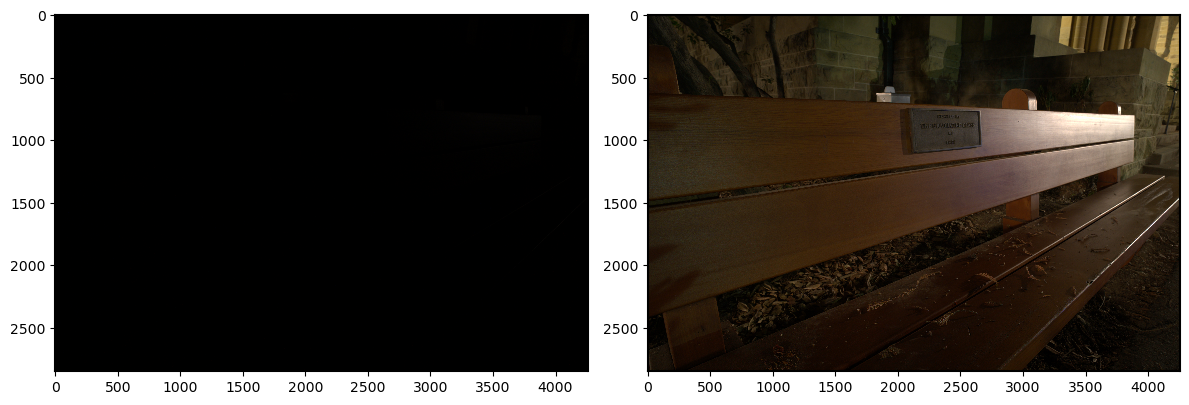

ISO:  400
F:  8.0


In [19]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6))
ax[1].imshow(im_long)
ax[0].imshow(im_short)
plt.tight_layout()
plt.show()
print("ISO: ", train_df.iso[rand_idx])
print("F: ", train_df.f[rand_idx])

In [20]:
ps = 256

def get_image_raw(path):
    return rawpy.imread(path)


def short_exposure_preprocess(raw):
    im = raw.postprocess(use_camera_wb=True, half_size=False, no_auto_bright=True, output_bps=16)
    im = np.maximum(im - 512, 0) / (16383 - 512) # black leveling
    # im = np.float32(im) / 65535.0

    return im

def long_exposure_preprocess(raw):
    im = raw.postprocess(use_camera_wb=True, half_size=False, no_auto_bright=True, output_bps=16)
    # im = (np.maximum(im - 512, 0)+512) / (16383 - 512)
    im = np.float32(im) / 65535.0

    return im

def augment(images: tuple):
    assert len(images) == 2, "Need 2 images for augmentation"
    im1, im2 = images

    if random.randint(0, 1) == 1:
        im1 = np.flip(im1, axis=1)
        im2 = np.flip(im2, axis=1)

    if random.randint(0, 1) == 1:
        im1 = np.flip(im1, axis=2)
        im2 = np.flip(im2, axis=2)

    return im1, im2

def resize(im_s, im_l, ps):
    patch_s = tf.image.resize(im_s, [ps, ps], antialias = True, method = 'nearest')
    patch_l = tf.image.resize(im_l, [ps, ps], antialias = True, method = 'nearest')

    return patch_s, patch_l

In [32]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
TRAIN_BATCH_SIZE = 4
VAL_BATCH_SIZE = 2
TEST_BATCH_SIZE = 24

def train_gen():
    x_paths, y_paths = train_df['short'][:1200], train_df['long'][:1200]
    for x, y in zip(x_paths, y_paths):
        yield augment(resize(short_exposure_preprocess(get_image_raw(x)), long_exposure_preprocess(get_image_raw(y)), ps))

ds_train = tf.data.Dataset.from_generator(
    train_gen,
    output_signature=(
         tf.TensorSpec(shape=(None, None, 3), dtype=np.float32),
         tf.TensorSpec(shape=(None, None, 3), dtype=np.float32)
    )
)

ds_train = ds_train.cache()
ds_train = ds_train.batch(TRAIN_BATCH_SIZE)
ds_train = ds_train.prefetch(AUTOTUNE)

def val_gen():
    x_paths, y_paths = val_df['short'], val_df['long']
    for x, y in zip(x_paths, y_paths):
        yield resize(short_exposure_preprocess(get_image_raw(x)), long_exposure_preprocess(get_image_raw(y)), ps)

ds_val = tf.data.Dataset.from_generator(
    val_gen,
    output_signature=(
         tf.TensorSpec(shape=(None, None, 3), dtype=np.float32),
         tf.TensorSpec(shape=(None, None, 3), dtype=np.float32)
    )
)

ds_val = ds_val.cache()
ds_val = ds_val.batch(VAL_BATCH_SIZE)
ds_val = ds_val.prefetch(AUTOTUNE)

def test_gen():
    x_paths, y_paths = test_df['short'], test_df['long']
    for x, y in zip(x_paths, y_paths):
        yield resize(short_exposure_preprocess(get_image_raw(x)), long_exposure_preprocess(get_image_raw(y)), ps)

ds_test = tf.data.Dataset.from_generator(
    test_gen,
    output_signature=(
         tf.TensorSpec(shape=(None, None, 3), dtype=np.float32),
         tf.TensorSpec(shape=(None, None, 3), dtype=np.float32)
    )
)

ds_test = ds_test.batch(TEST_BATCH_SIZE)
ds_test = ds_test.prefetch(AUTOTUNE)

In [22]:
from utils import UNet, SRE, SSIM

In [23]:
model = UNet()
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = tf.keras.losses.MeanAbsoluteError(),
              metrics = [SRE, SSIM])

In [24]:
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

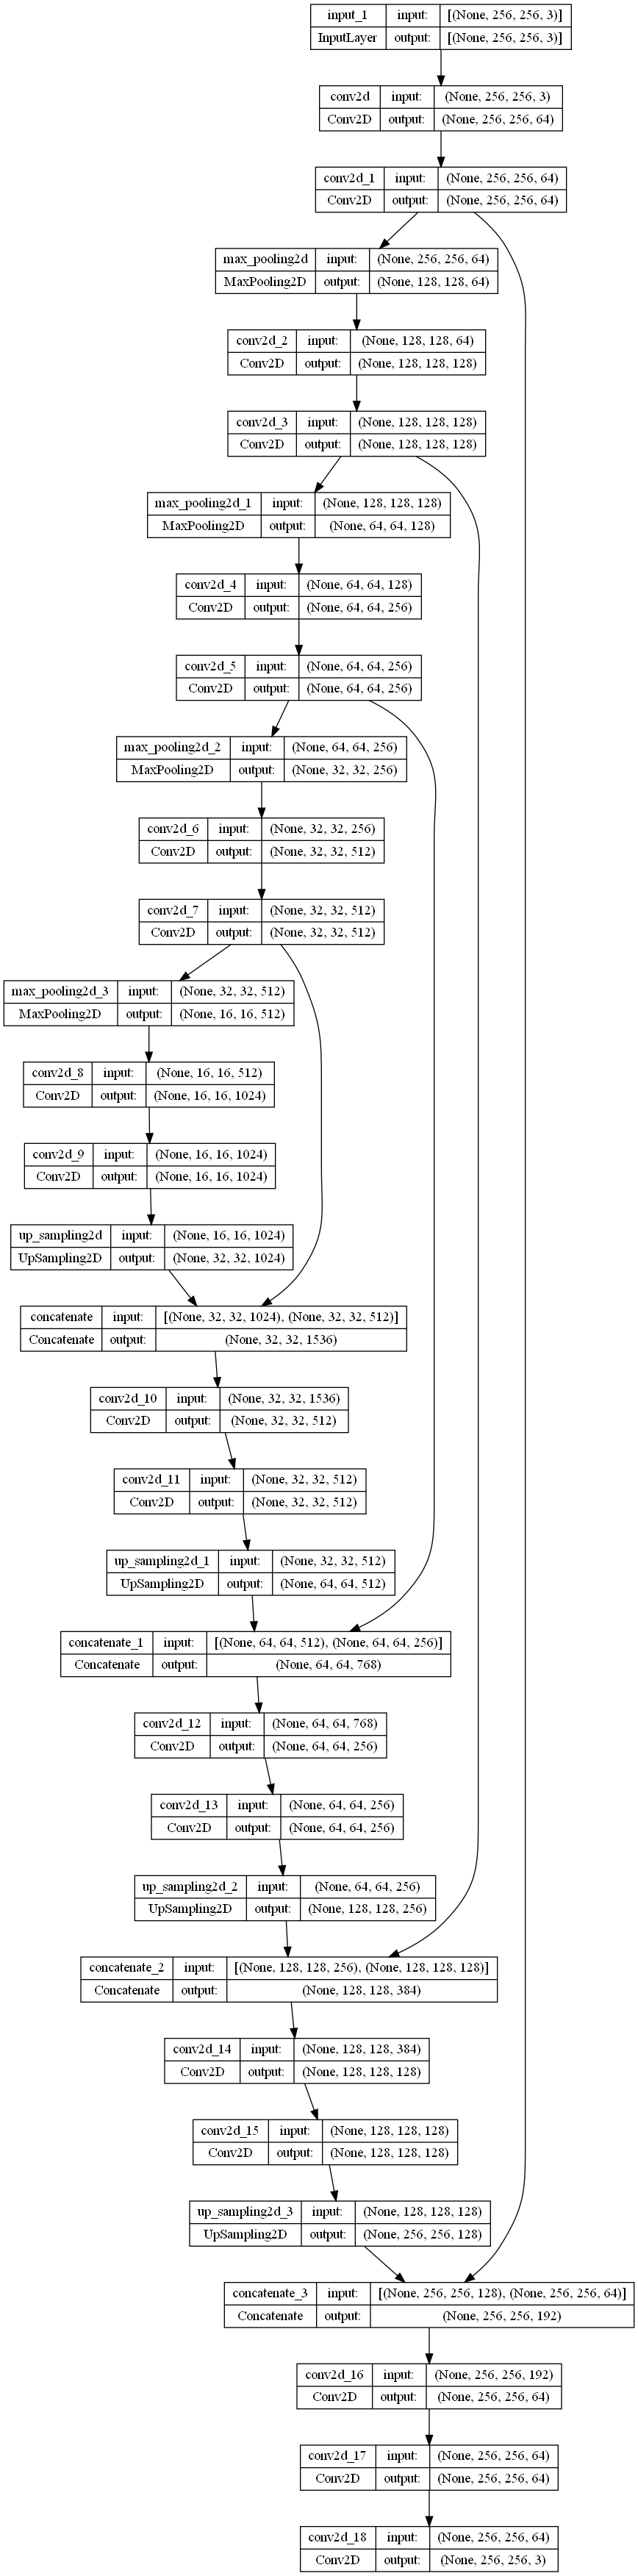

In [25]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

In [26]:
# 1 GPU
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.2,
    patience = 3,
    min_lr = 1e-7
)

!mkdir training
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "./training/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

n_batches = train_df.shape[0] // TRAIN_BATCH_SIZE

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path,
    verbose = 1,
    save_weights_only = True)

A subdirectory or file training already exists.


In [28]:
hist = model.fit(
    ds_train,
    epochs = 2,
    validation_data = ds_val,
    callbacks=[reduce_lr, cp_callback]
)

Epoch 1/2
    300/Unknown - 3025s 10s/step - loss: 0.2153 - SRE: 0.0495 - SSIM: 1.0000WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,SRE,SSIM,lr

Epoch 1: saving model to ./training\cp-0001.ckpt
300/300 [==============================] - 3029s 10s/step - loss: 0.2153 - SRE: 0.0495 - SSIM: 1.0000 - lr: 0.0010
Epoch 2/2
300/300 [==============================] - ETA: 0s - loss: 0.2153 - SRE: 0.0495 - SSIM: 1.0000 WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,SRE,SSIM,lr

Epoch 2: saving model to ./training\cp-0002.ckpt
300/300 [==============================] - 3217s 11s/step - loss: 0.2153 - SRE: 0.0495 - SSIM: 1.0000 - lr: 0.0010


In [34]:
def plot_pair(x, y, y_h):
    fig, ax = plt.subplots(1, 3, figsize = (10, 5))
    ax[0].imshow(x)
    ax[1].imshow(y)
    ax[2].imshow(y_h)
    plt.tight_layout()
    plt.show()

1/1 [==============================] - 1s 1s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


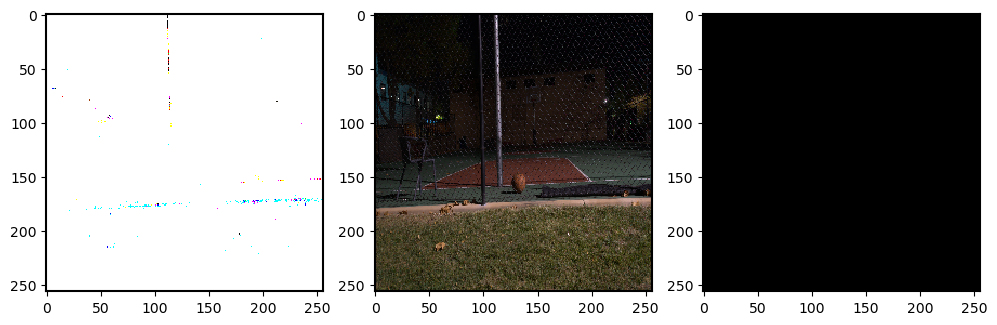

1/1 [==============================] - 1s 617ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


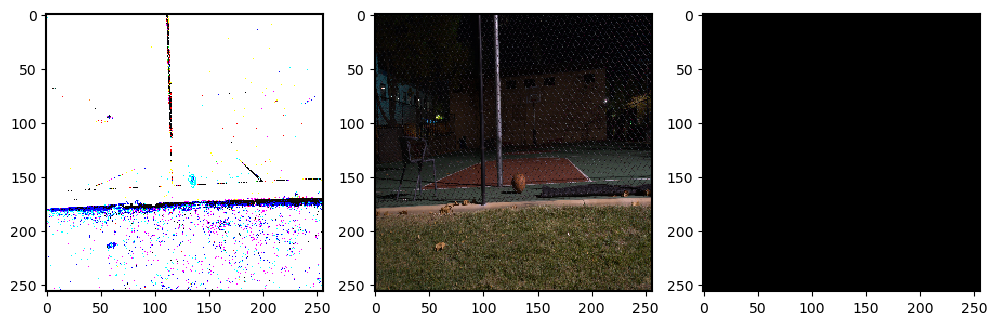

1/1 [==============================] - 1s 619ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


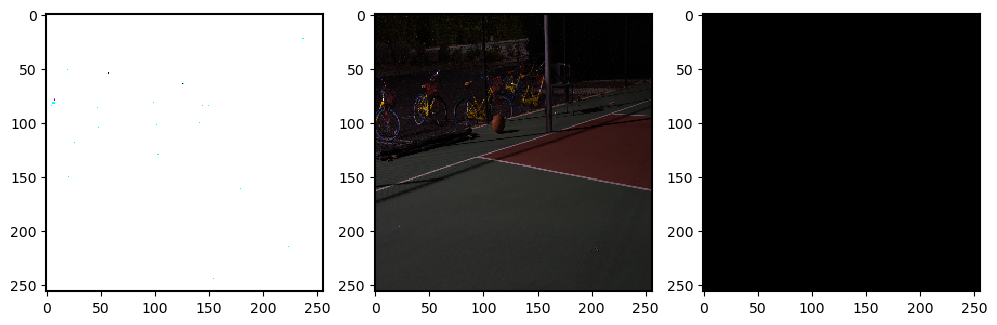

1/1 [==============================] - 1s 658ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


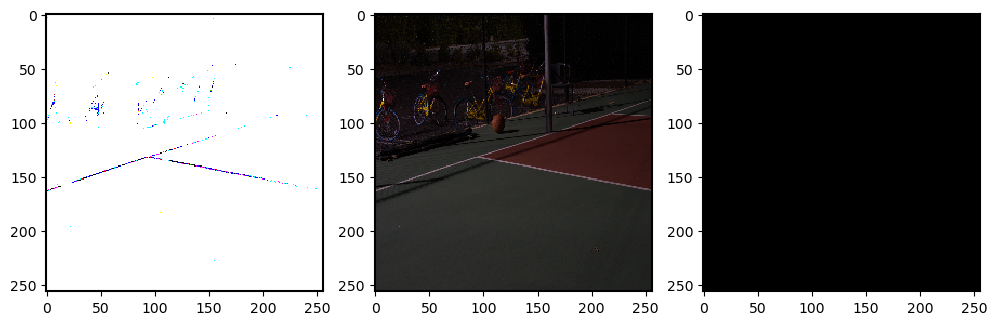

In [35]:
test_batch = next(iter(ds_test))

t = model.predict(tf.expand_dims(test_batch[0][0], axis = 0))[0]
plot_pair(test_batch[0][0], test_batch[1][0], t)

t = model.predict(tf.expand_dims(test_batch[0][1], axis = 0))[0]
plot_pair(test_batch[0][1], test_batch[1][1], t)

t = model.predict(tf.expand_dims(test_batch[0][14], axis = 0))[0]
plot_pair(test_batch[0][14], test_batch[1][14], t)

t = model.predict(tf.expand_dims(test_batch[0][14], axis = 0))[0]
plot_pair(test_batch[0][15], test_batch[1][15], t)